In [1]:
from os import listdir, system
from sys import argv

import numpy as np


from modules.spline import *
from modules.stats import *
from modules.helper_functions import *
from modules.plot_functions import *

import __main__

In [2]:
executed_as_python = hasattr(__main__, '__file__')
saveimage = False
if executed_as_python:
    matplotlib.use('Agg')
    saveimage = True

In [3]:
# Insert Elvis directory here
elvis_iso_dir = "../../../Project/Elvis/IsolatedTrees"

# Insert suite name here
suite_name = "iBurr"

if executed_as_python:
    suite_name = argv[1]

In [4]:
# Do not modify
data = read_elvis_tracks(elvis_iso_dir, suite_name,varnames = ['Mvir','scale','X','Y','Z','ID','pID','Rvir','Vx','Vy','Vz'])


0it [00:00, ?it/s]

In [5]:
_, lookback_time0, X0, Y0, Z0, Vx0, Vy0, Vz_0, Mvir0, Rvir0, coefs_X0, coefs_Y0, coefs_Z0, coefs_Mvir0, coefs_Rvir0 = extract_data(data, 0, isCoefsPos = True, isCoefsMvir = True, isCoefsRvir = True)

In [6]:
plot_pretty()

In [7]:
num_halos = get_num_halos(data)
num_time = get_num_time(data)

In [8]:
arr_row, arr_time, arr_pos_acc, arr_vec_acc, arr_ang_pos_acc, arr_ang_vec_acc, arr_pos_cur, arr_vec_cur, arr_ang_pos_cur, arr_ang_vec_cur, arr_pos_cur_dis, arr_vec_cur_dis, arr_mass_acc, arr_mass_cur = get_arrays(suite_name, data)

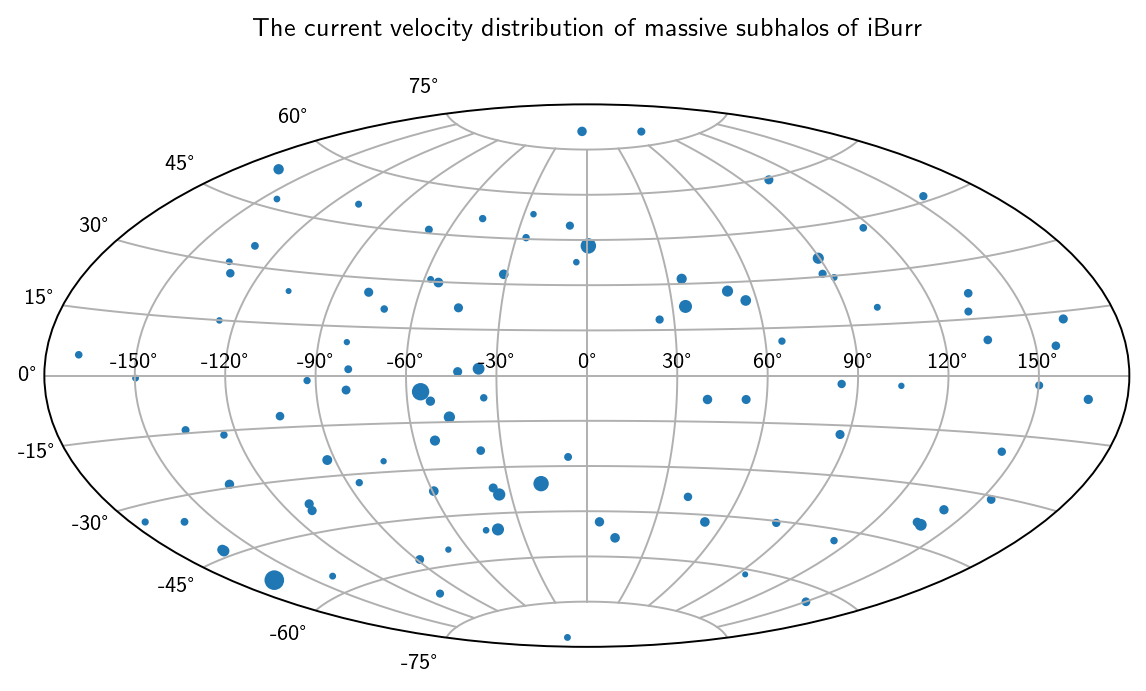

In [9]:
title = "The current velocity distribution of massive subhalos of {}"
img_name = "../../result/data/{}/current_velocity_distribution_of_subhalos_of_{}.pdf"

plot_spherical_coordinates(suite_name, arr_ang_vec_cur, arr_mass_cur, title, img_name, saveimage = saveimage)

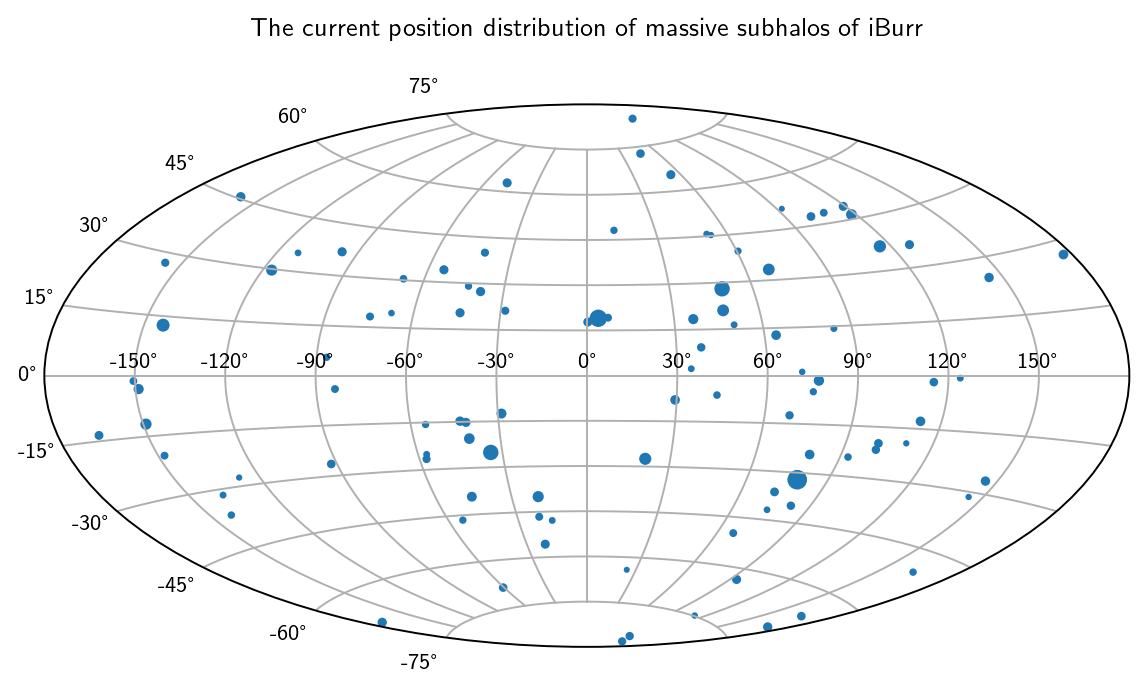

In [10]:
title = "The current position distribution of massive subhalos of {}"
img_name = "../../result/data/{}/current_position_distribution_of_subhalos_of_{}.pdf"

plot_spherical_coordinates(suite_name, arr_ang_pos_cur, arr_mass_cur, title, img_name, saveimage = saveimage)

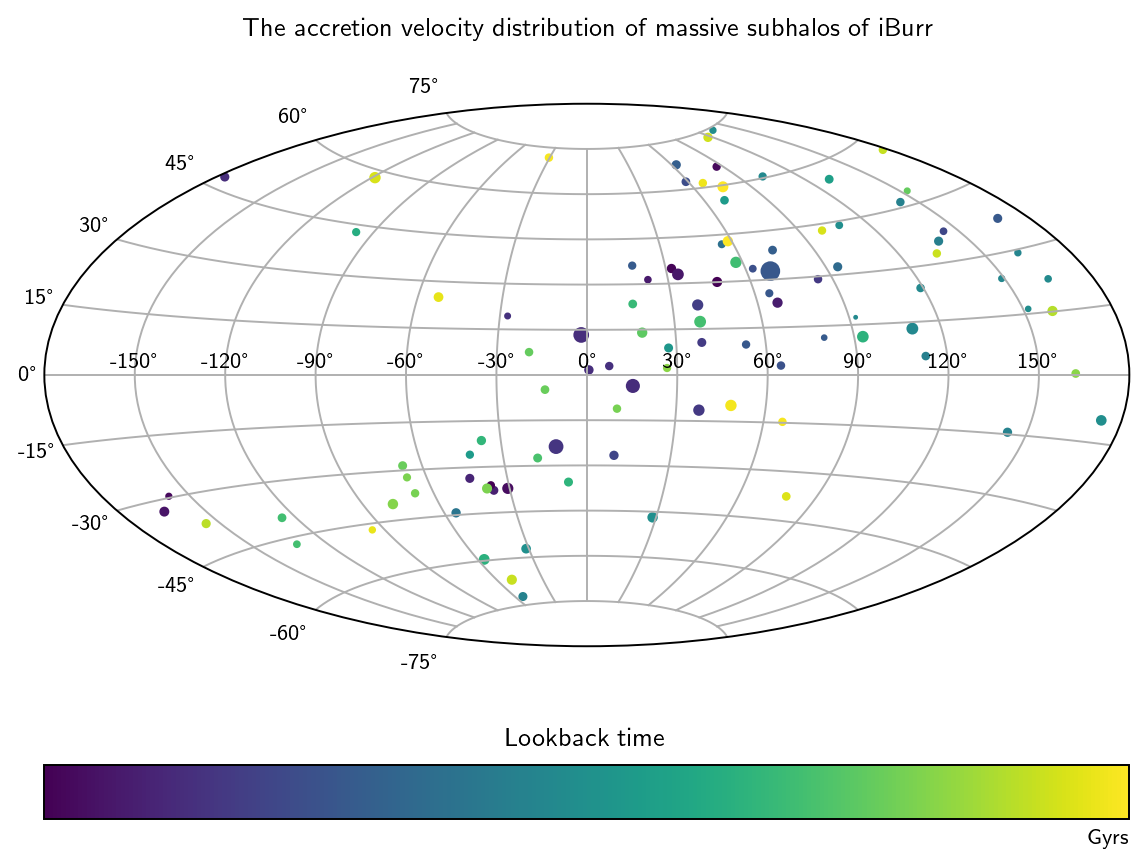

In [11]:
title = "The accretion velocity distribution of massive subhalos of {}"
img_name = "../../result/data/{}/accretion_velocity_distribution_of_subhalos_of_{}.pdf"

plot_spherical_coordinates(suite_name, arr_ang_vec_acc, arr_mass_acc, title, img_name, arr_time = arr_time, isColorBar = True, saveimage = saveimage)

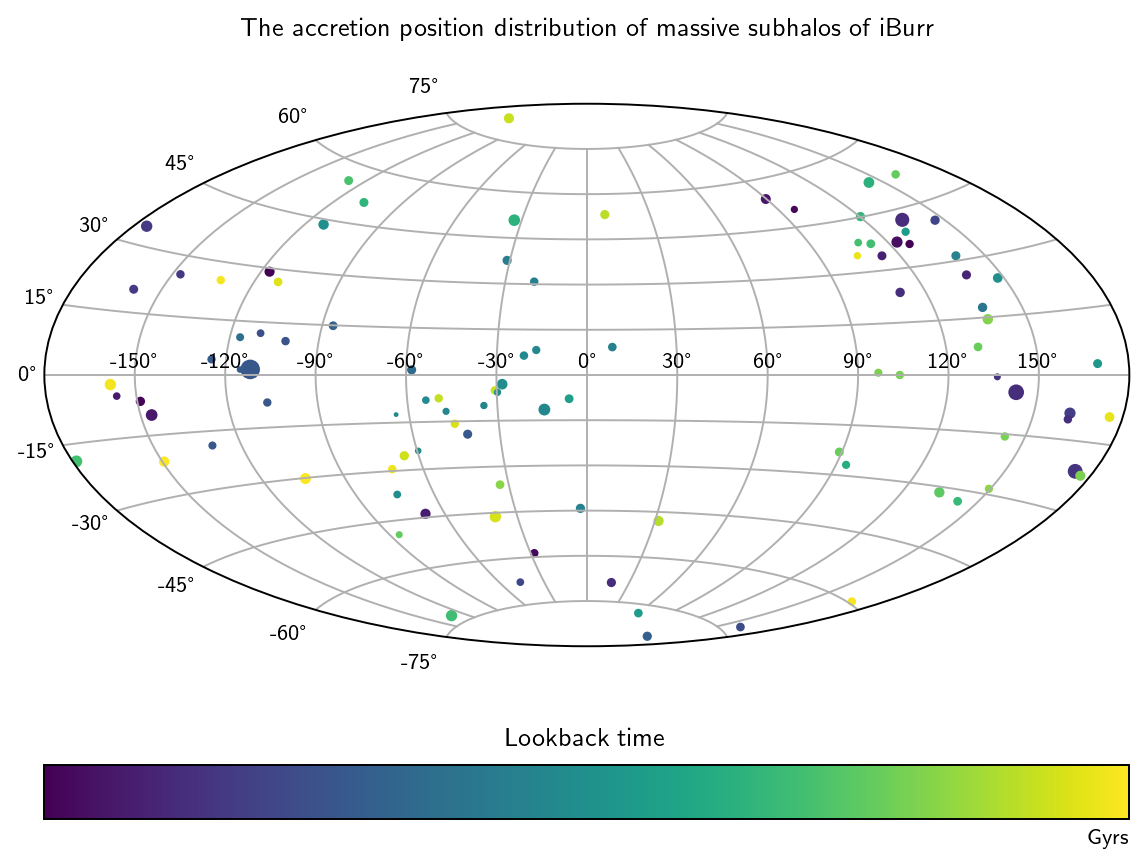

In [12]:
title = "The accretion position distribution of massive subhalos of {}"
img_name = "../../result/data/{}/accretion_position_distribution_of_subhalos_of_{}.pdf"

plot_spherical_coordinates(suite_name, arr_ang_pos_acc, arr_mass_acc, title, img_name, arr_time = arr_time, isColorBar = True, saveimage = saveimage)

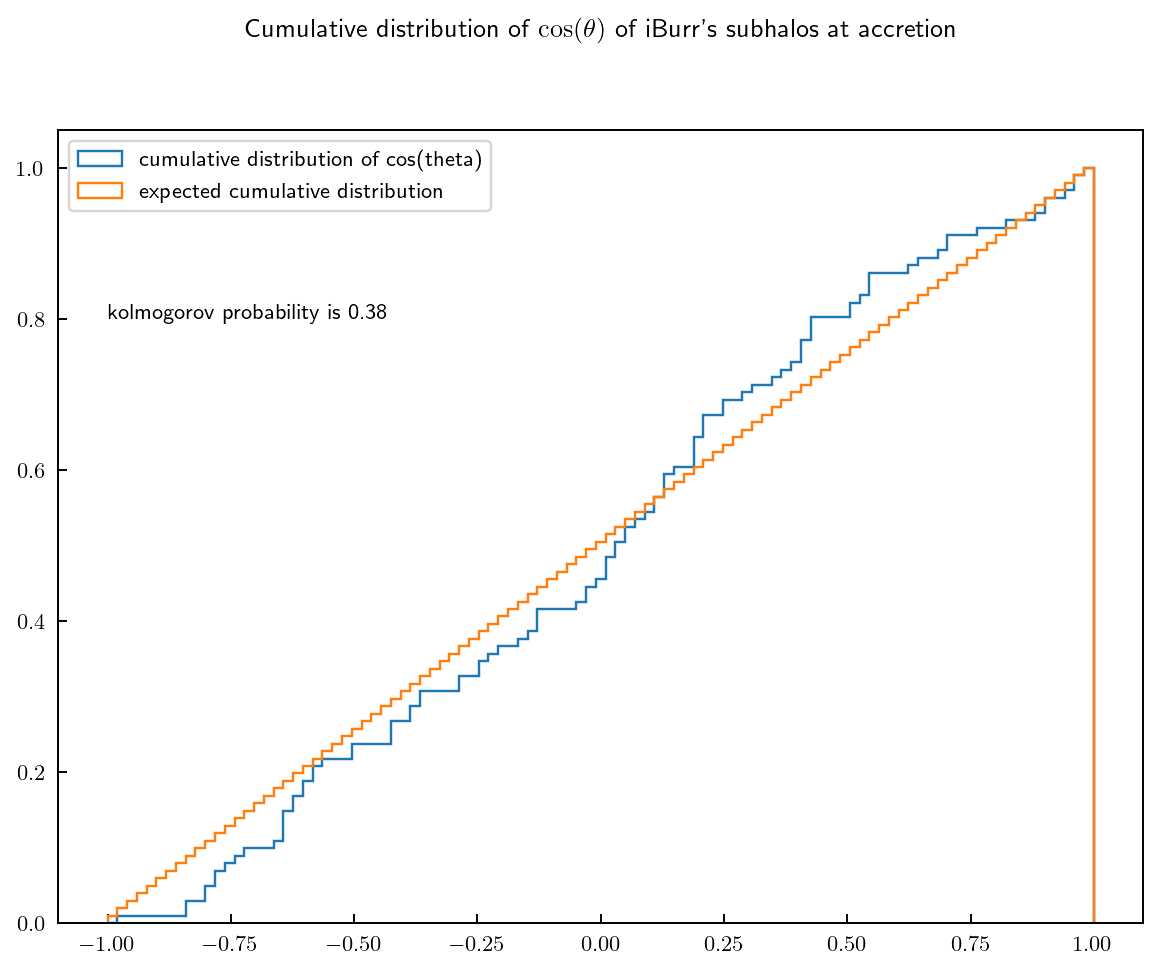

In [13]:
title = "Cumulative distribution of $\cos(\\theta)$ of {}'s subhalos at accretion"
img_name = "../../result/data/{}/cumulative_angular_distribution_of_{}.pdf"

plot_kolmogorov(suite_name, arr_pos_acc, title, img_name, saveimage = False)

<IPython.core.display.Javascript object>


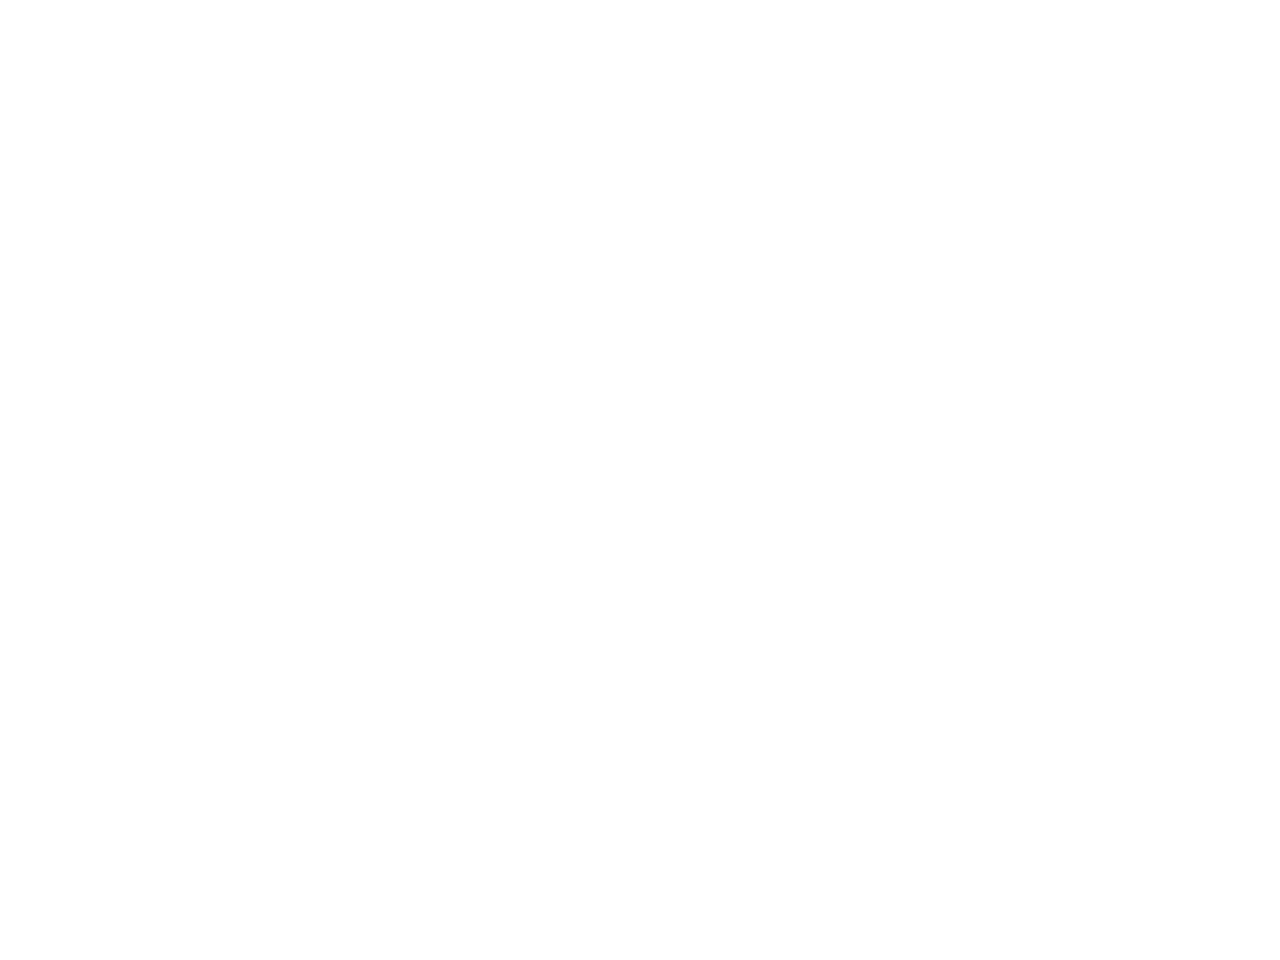

In [14]:
if not executed_as_python:
    %matplotlib notebook
    title = 'accretion distribution of subhalos of {}'
    plot_quiver(suite_name, arr_pos_acc, arr_vec_acc, title, arr_time = arr_time, isColor = True)

<IPython.core.display.Javascript object>


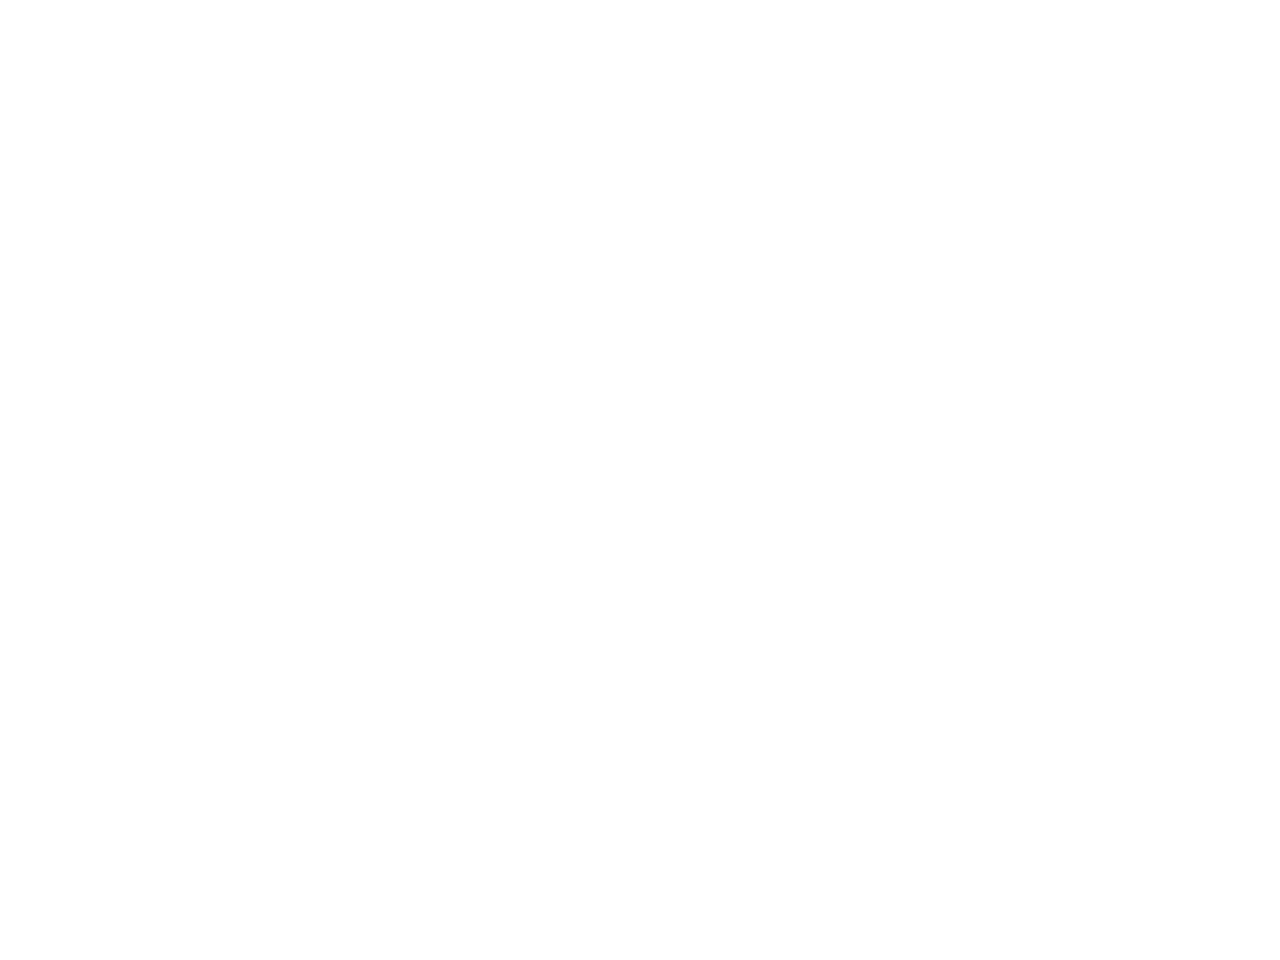

In [15]:
if not executed_as_python:
    %matplotlib notebook
    title = "current distribution of subhalos of {}"
    plot_quiver(suite_name, arr_pos_cur, arr_vec_cur, title)

<IPython.core.display.Javascript object>


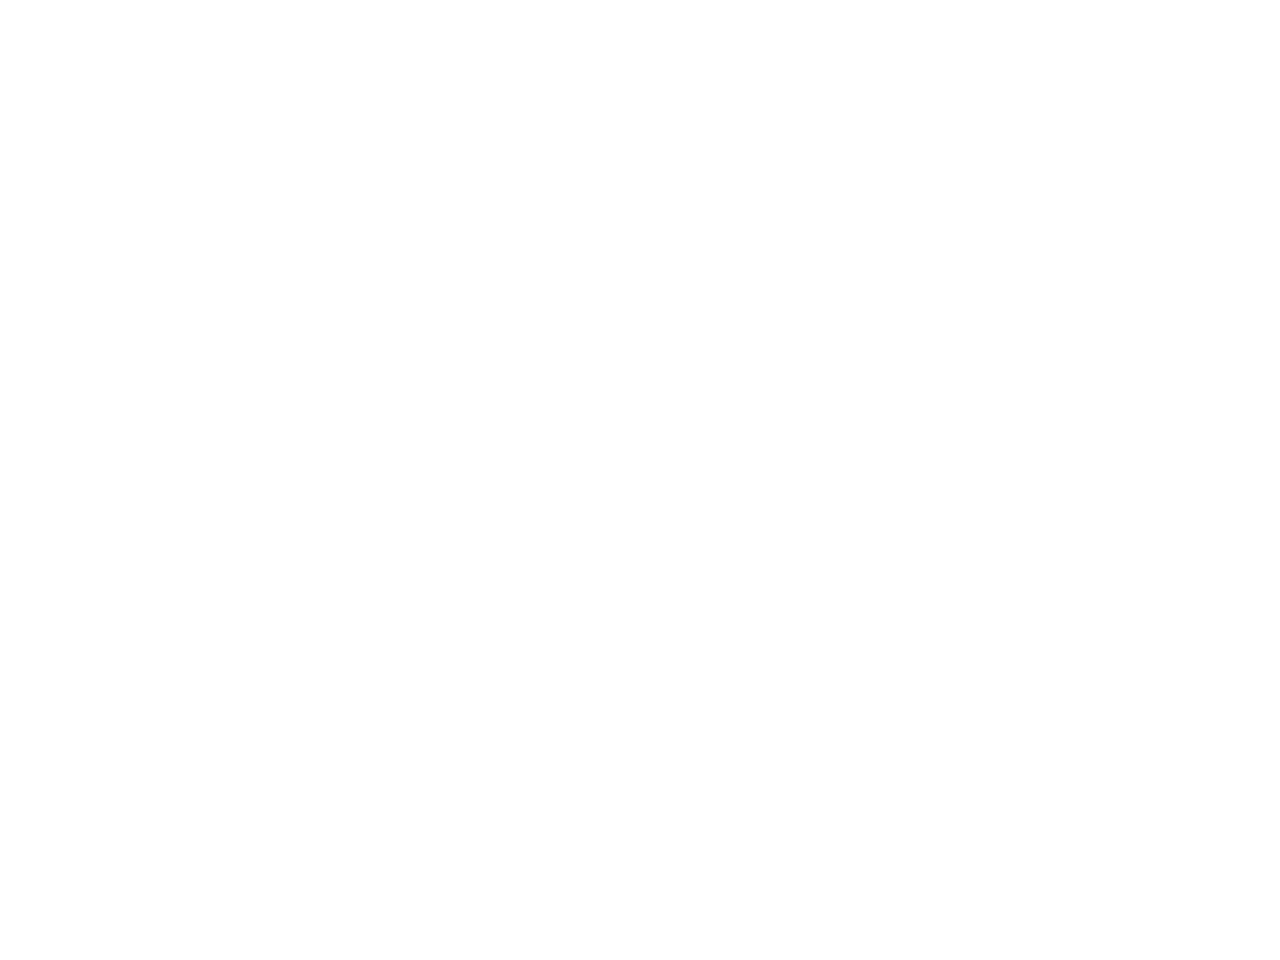

In [16]:
if not executed_as_python:
    %matplotlib notebook
    title = "current distribution with distance of subhalos of {}"
    plot_quiver(suite_name, arr_pos_cur_dis, arr_vec_cur_dis, title)

<IPython.core.display.Javascript object>


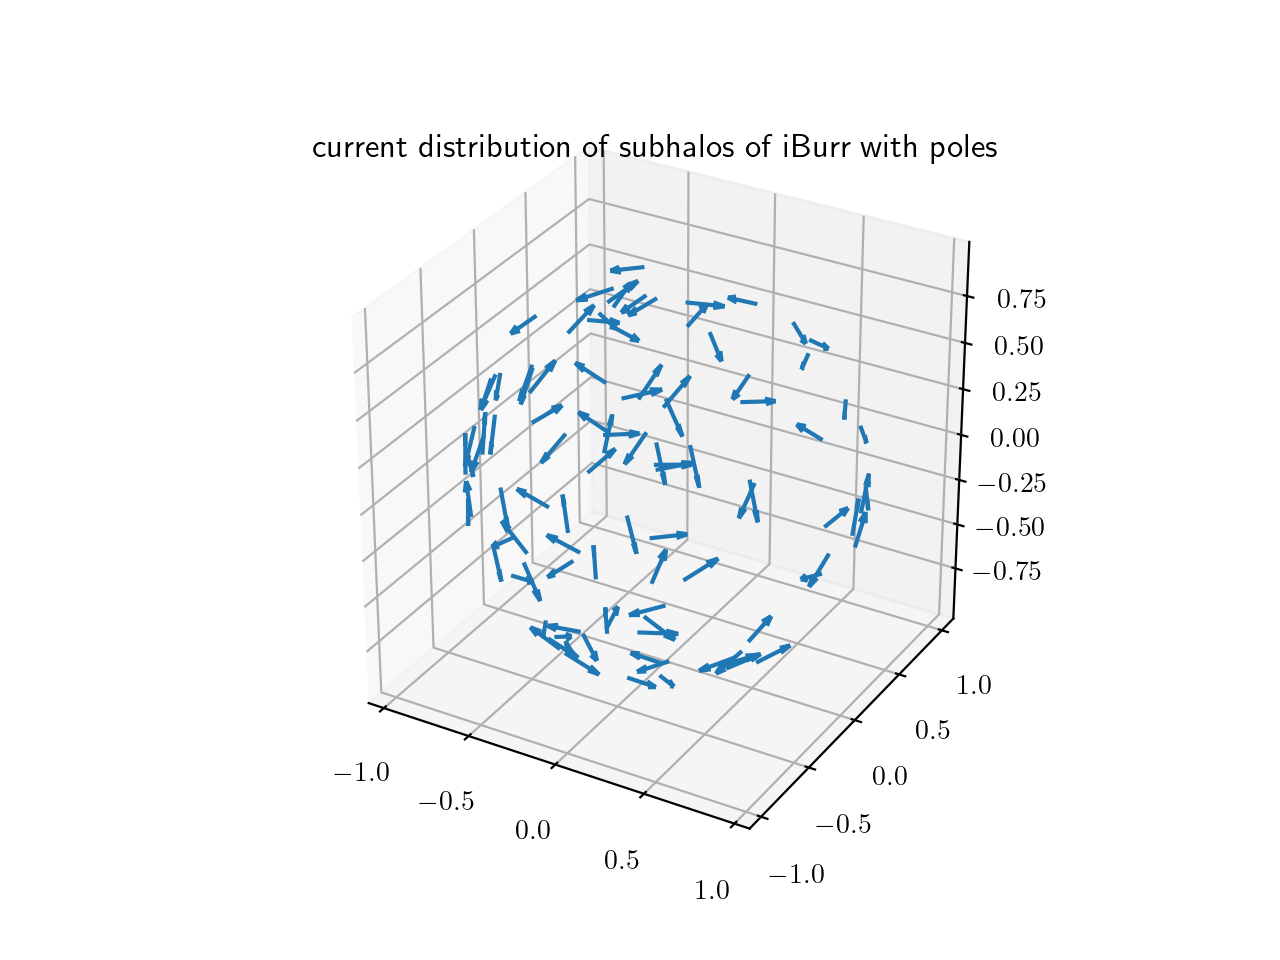

In [17]:
if not executed_as_python:
    %matplotlib notebook
    
    title = "current distribution of subhalos of {} with poles"
    
    poles = np.cross(arr_pos_cur, arr_vec_cur).T
    temp = (np.sum(poles**2, axis = 0))**(1/2)
    poles = np.array([poles[0]/temp, poles[1]/temp, poles[2]/temp]).T
    
    plot_quiver(suite_name, arr_pos_cur, poles, title)

<IPython.core.display.Javascript object>


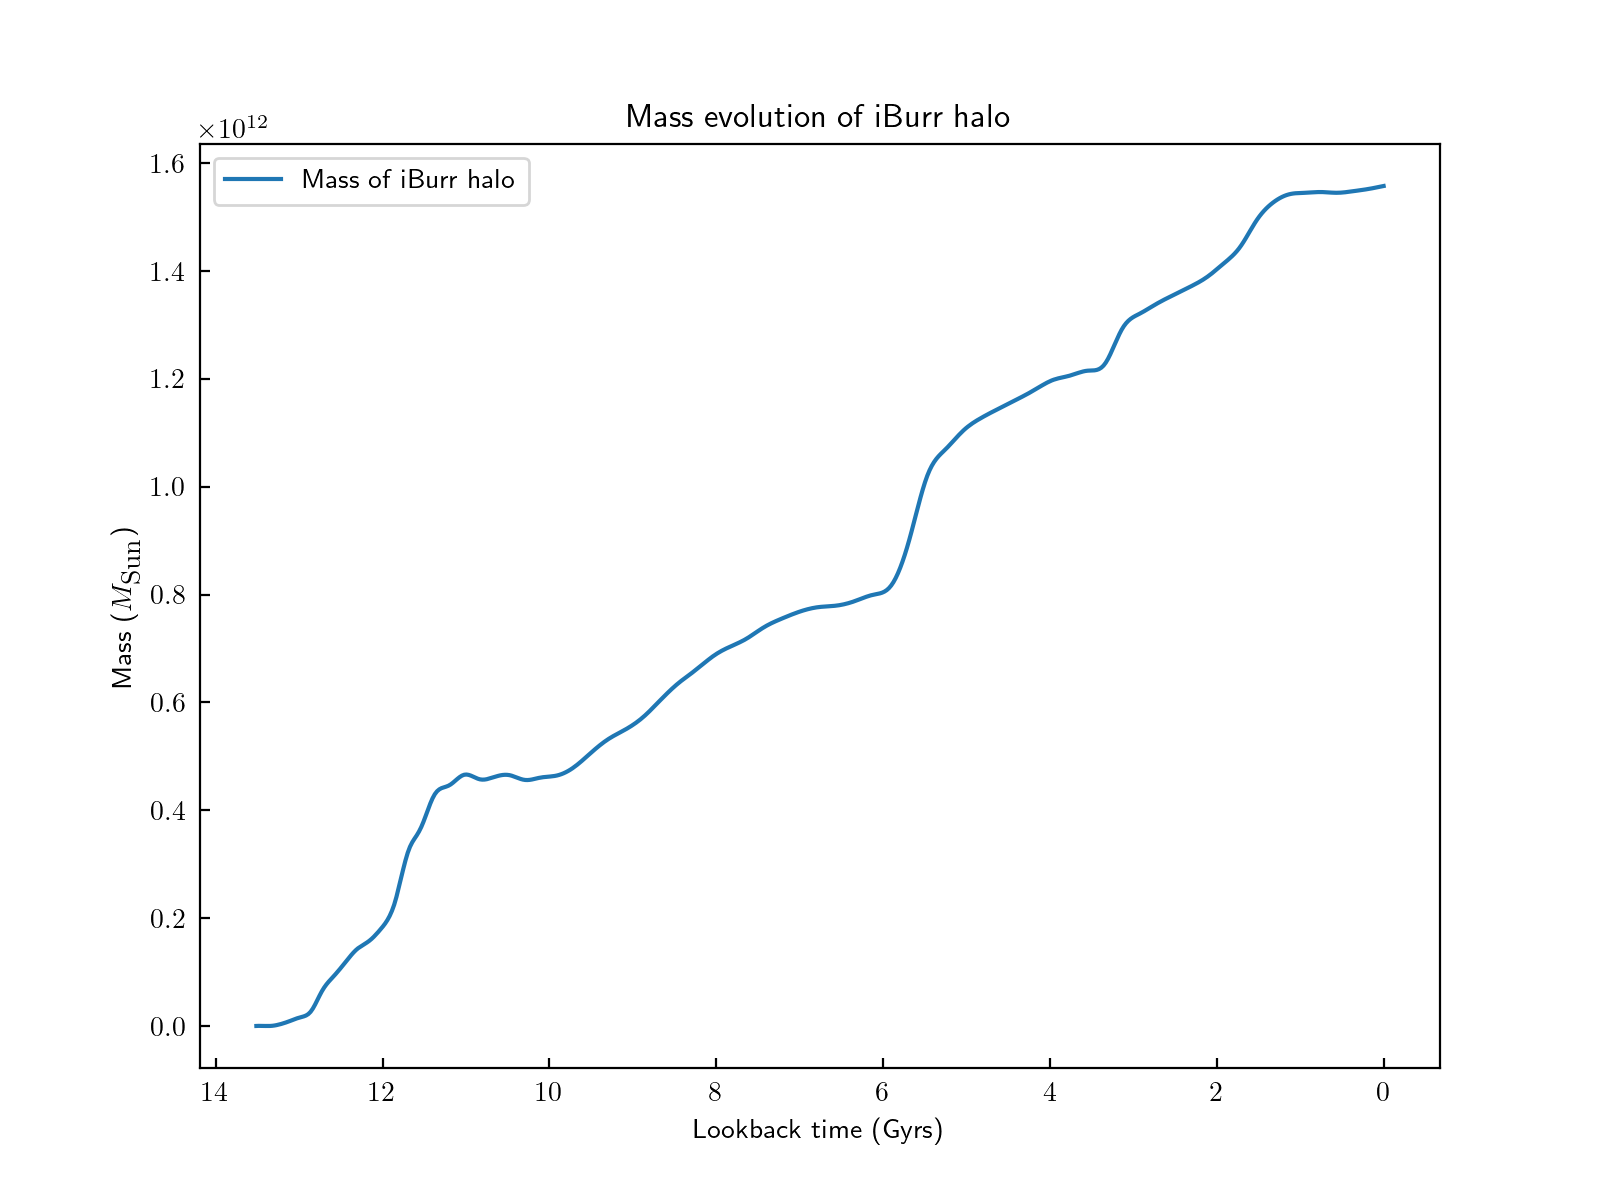

In [18]:
plot_evolution(suite_name, lookback_time0, coefs_Mvir0, "Mass")

<IPython.core.display.Javascript object>


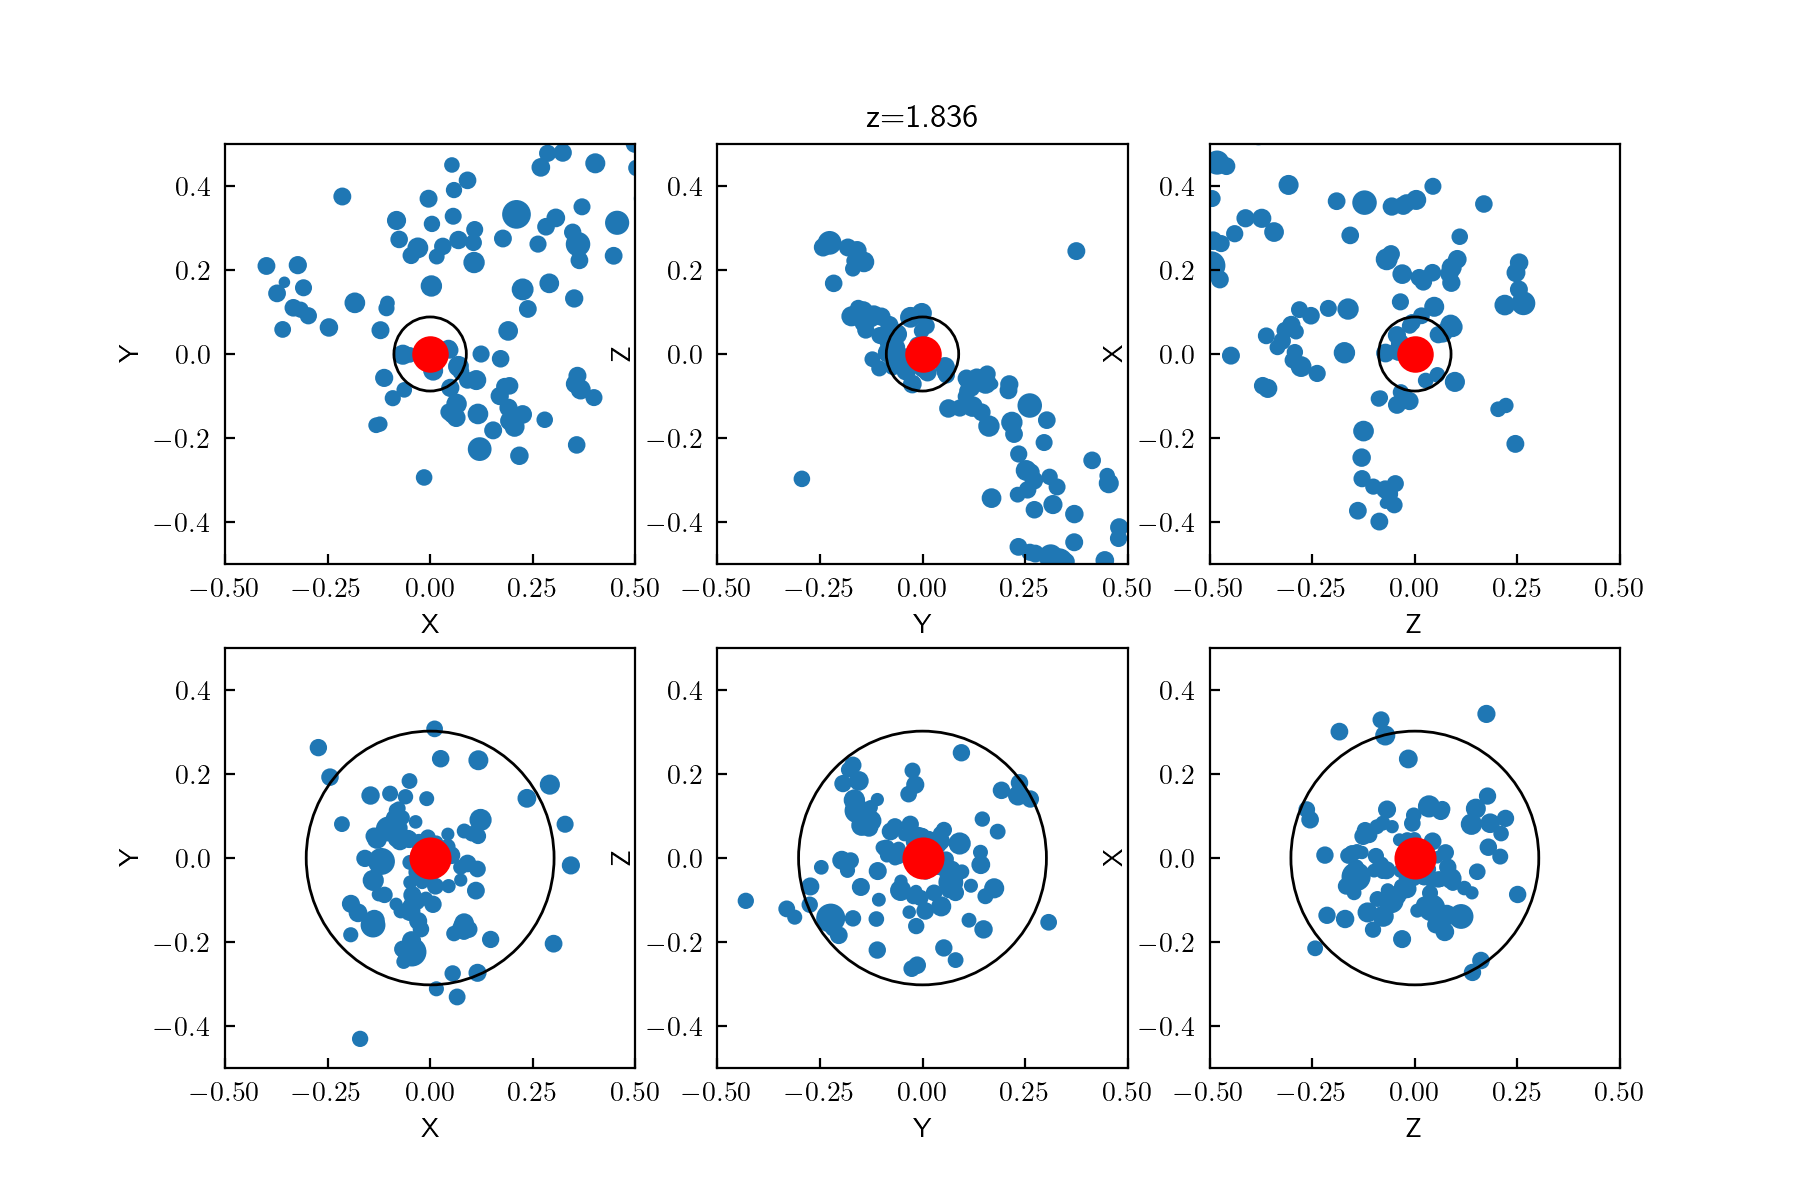

In [19]:
anim = make_animations(suite_name, data, arr_row, num_time, saveimage)

<IPython.core.display.Javascript object>


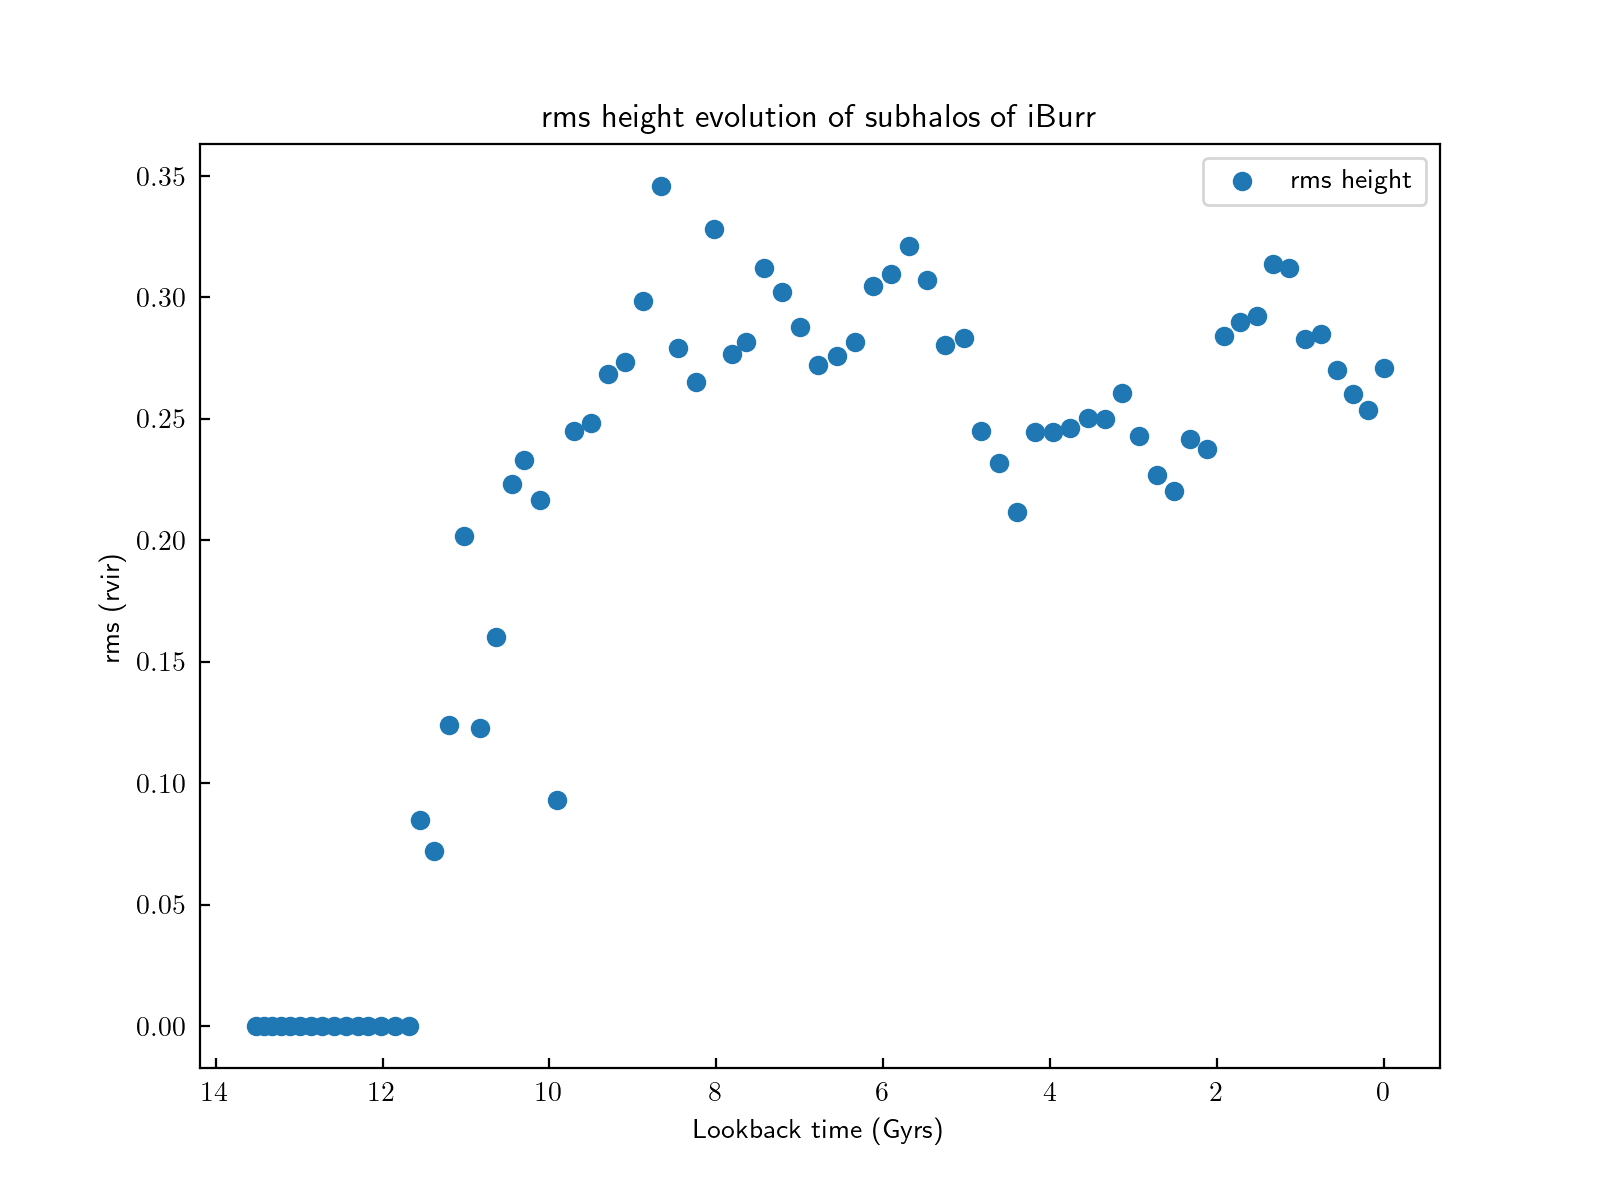

In [20]:
img_name = "../../result/data/{}/rms_height_evolution_of_subhalos_of_{}.pdf"
plot_rms(suite_name, data, arr_row, lookback_time0, X0, Y0, Z0, Rvir0, img_name, saveimage = saveimage)